# KBLI LLM Classification Results Analysis

This notebook analyzes the results from LLM processing of KBLI classification tasks. It examines self-consistency across multiple runs, confidence distributions, and model performance metrics.

## Overview
- **Data Source**: JSONL files from LLM processing pipeline
- **Analysis Focus**: Self-consistency, confidence scores, classification accuracy
- **Models**: Multiple Gemini model variants
- **Methodology**: 3 runs per UUID for voting-based classification

## 1. Import Required Libraries

Import necessary libraries for data analysis, visualization, and statistical calculations.

In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
from collections import Counter, defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure visualization settings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis started at: 2025-07-30 11:48:01


## 2. Load JSONL Data

Load and parse JSONL files from the results directory. Handle multiple model results and combine them for analysis.

In [5]:
def load_jsonl_files(directory_path="../results/pilot/extract_llm/"):
    """
    Load all JSONL files from the specified directory.
    
    Returns:
        dict: Dictionary with filename as key and DataFrame as value
    """
    results_dir = Path(directory_path)
    jsonl_files = list(results_dir.glob("*.jsonl"))
    
    if not jsonl_files:
        print(f"No JSONL files found in {results_dir}")
        return {}
    
    print(f"Found {len(jsonl_files)} JSONL files:")
    for file in jsonl_files:
        print(f"  - {file.name}")
    
    all_data = {}
    
    for file_path in jsonl_files:
        print(f"\nLoading {file_path.name}...")
        
        data = []
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    line = line.strip()
                    if line:
                        try:
                            record = json.loads(line)
                            data.append(record)
                        except json.JSONDecodeError as e:
                            print(f"  Warning: Invalid JSON on line {line_num}: {e}")
                            continue
            
            if data:
                df = pd.DataFrame(data)
                # Add source filename for tracking
                df['source_file'] = file_path.name
                all_data[file_path.name] = df
                print(f"  Loaded {len(df)} records")
            else:
                print(f"  No valid records found")
                
        except Exception as e:
            print(f"  Error loading file: {e}")
    
    return all_data

# Load all JSONL files
jsonl_data = load_jsonl_files()

if jsonl_data:
    # Combine all data into a single DataFrame
    combined_df = pd.concat(jsonl_data.values(), ignore_index=True)
    print(f"\nCombined dataset: {len(combined_df)} total records")
    print(f"Unique models: {combined_df['model'].nunique()}")
    print(f"Unique UUIDs: {combined_df['uuid'].nunique()}")
else:
    print("No data loaded. Please check the file path and ensure JSONL files exist.")

Found 1 JSONL files:
  - mini_test_with_ids_gemini-2_5-flash-lite.jsonl

Loading mini_test_with_ids_gemini-2_5-flash-lite.jsonl...
  Loaded 630 records

Combined dataset: 630 total records
Unique models: 1
Unique UUIDs: 210


## 3. Data Exploration and Overview

Examine the structure and basic properties of the loaded LLM results data.

In [6]:
if 'combined_df' in locals() and not combined_df.empty:
    print("=== DATASET OVERVIEW ===")
    print(f"Shape: {combined_df.shape}")
    print(f"Memory usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n=== COLUMN INFORMATION ===")
    print("Columns and data types:")
    for col, dtype in combined_df.dtypes.items():
        non_null_count = combined_df[col].notna().sum()
        print(f"  {col}: {dtype} ({non_null_count}/{len(combined_df)} non-null)")
    
    print(f"\n=== PROCESSING STATISTICS ===")
    print(f"Unique UUIDs: {combined_df['uuid'].nunique()}")
    print(f"Unique models: {combined_df['model'].nunique()}")
    print(f"Run distribution:")
    print(combined_df['run_id'].value_counts().sort_index())
    
    print(f"\n=== MODEL BREAKDOWN ===")
    model_stats = combined_df.groupby('model').agg({
        'uuid': 'nunique',
        'run_id': 'count',
        'is_correct': 'mean',
        'confidence_score': 'mean'
    }).round(3)
    model_stats.columns = ['Unique UUIDs', 'Total Runs', 'Accuracy', 'Avg Confidence']
    print(model_stats)
    
    print(f"\n=== TIME RANGE ===")
    if 'timestamp' in combined_df.columns:
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
        print(f"First record: {combined_df['timestamp'].min()}")
        print(f"Last record: {combined_df['timestamp'].max()}")
        print(f"Processing duration: {combined_df['timestamp'].max() - combined_df['timestamp'].min()}")
    
    print(f"\n=== SAMPLE RECORDS ===")
    print("First few records:")
    print(combined_df[['uuid', 'kbli_code', 'run_id', 'model', 'is_correct', 'confidence_score']].head())
else:
    print("No data available for exploration. Please check the data loading step.")

=== DATASET OVERVIEW ===
Shape: (630, 13)
Memory usage: 1.12 MB

=== COLUMN INFORMATION ===
Columns and data types:
  uuid: object (630/630 non-null)
  text: object (630/630 non-null)
  kbli_code: object (630/630 non-null)
  run_id: int64 (630/630 non-null)
  model: object (630/630 non-null)
  timestamp: object (630/630 non-null)
  is_correct: bool (630/630 non-null)
  confidence_score: float64 (630/630 non-null)
  reasoning: object (630/630 non-null)
  alternative_codes: object (630/630 non-null)
  alternative_reasoning: object (630/630 non-null)
  api_metadata: object (630/630 non-null)
  source_file: object (630/630 non-null)

=== PROCESSING STATISTICS ===
Unique UUIDs: 210
Unique models: 1
Run distribution:
run_id
1    210
2    210
3    210
Name: count, dtype: int64

=== MODEL BREAKDOWN ===
                       Unique UUIDs  Total Runs  Accuracy  Avg Confidence
model                                                                    
gemini-2.5-flash-lite           210         63

## 4. Data Cleaning and Preprocessing

Clean and prepare the data for analysis, handling any inconsistencies or missing values.

In [7]:
if 'combined_df' in locals() and not combined_df.empty:
    # Create a clean copy for analysis
    df = combined_df.copy()
    
    print("=== DATA CLEANING ===")
    print(f"Original dataset: {len(df)} records")
    
    # Convert data types
    df['is_correct'] = df['is_correct'].astype(bool)
    df['confidence_score'] = pd.to_numeric(df['confidence_score'], errors='coerce')
    df['run_id'] = pd.to_numeric(df['run_id'], errors='coerce')
    
    # Handle timestamp
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values found:")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found.")
    
    # Validate confidence scores (should be 0-1)
    invalid_confidence = df[(df['confidence_score'] < 0) | (df['confidence_score'] > 1)]
    if len(invalid_confidence) > 0:
        print(f"\nWarning: {len(invalid_confidence)} records with invalid confidence scores")
        print("Confidence score range:", df['confidence_score'].min(), "to", df['confidence_score'].max())
    
    # Validate run_id (should be 1, 2, or 3)
    invalid_runs = df[~df['run_id'].isin([1, 2, 3])]
    if len(invalid_runs) > 0:
        print(f"\nWarning: {len(invalid_runs)} records with invalid run_id")
        print("Run ID values:", sorted(df['run_id'].unique()))
    
    # Check for complete sets (each UUID should have 3 runs)
    uuid_run_counts = df.groupby(['uuid', 'model'])['run_id'].count()
    incomplete_sets = uuid_run_counts[uuid_run_counts != 3]
    
    if len(incomplete_sets) > 0:
        print(f"\nWarning: {len(incomplete_sets)} UUID-model combinations don't have exactly 3 runs")
        print("Run count distribution:")
        print(uuid_run_counts.value_counts().sort_index())
    else:
        print(f"\nAll {len(uuid_run_counts)} UUID-model combinations have complete sets (3 runs each)")
    
    # Create summary statistics
    print(f"\n=== CLEANED DATASET SUMMARY ===")
    print(f"Records: {len(df)}")
    print(f"Unique UUIDs: {df['uuid'].nunique()}")
    print(f"Models: {df['model'].nunique()}")
    print(f"KBLI codes: {df['kbli_code'].nunique()}")
    
    print("\nData ready for analysis!")
else:
    print("No data available for cleaning.")

=== DATA CLEANING ===
Original dataset: 630 records
No missing values found.

All 210 UUID-model combinations have complete sets (3 runs each)

=== CLEANED DATASET SUMMARY ===
Records: 630
Unique UUIDs: 210
Models: 1
KBLI codes: 43

Data ready for analysis!


## 5. Statistical Analysis

Perform comprehensive statistical analysis including self-consistency, confidence distributions, and performance metrics.

In [8]:
### 5.1 Self-Consistency Analysis

def analyze_self_consistency(df):
    """Analyze agreement between the 3 runs for each UUID-model combination."""
    
    results = {}
    
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        
        # Group by UUID and analyze consistency
        consistency_stats = []
        
        for uuid in model_data['uuid'].unique():
            uuid_data = model_data[model_data['uuid'] == uuid]
            
            if len(uuid_data) == 3:  # Complete set
                is_correct_votes = uuid_data['is_correct'].tolist()
                confidence_scores = uuid_data['confidence_score'].tolist()
                
                # Agreement analysis
                agreement_count = sum(is_correct_votes)
                is_unanimous = agreement_count in [0, 3]
                is_majority = agreement_count >= 2
                
                consistency_stats.append({
                    'uuid': uuid,
                    'votes_correct': agreement_count,
                    'unanimous': is_unanimous,
                    'majority_correct': is_majority,
                    'confidence_mean': np.mean(confidence_scores),
                    'confidence_std': np.std(confidence_scores),
                    'confidence_min': min(confidence_scores),
                    'confidence_max': max(confidence_scores)
                })
        
        if consistency_stats:
            consistency_df = pd.DataFrame(consistency_stats)
            
            # Calculate model-level statistics
            model_stats = {
                'total_uuids': len(consistency_df),
                'unanimous_agreement': consistency_df['unanimous'].sum(),
                'majority_correct': consistency_df['majority_correct'].sum(),
                'unanimous_correct': consistency_df[consistency_df['votes_correct'] == 3].shape[0],
                'unanimous_incorrect': consistency_df[consistency_df['votes_correct'] == 0].shape[0],
                'split_decisions': consistency_df[consistency_df['votes_correct'] == 1].shape[0] + 
                                 consistency_df[consistency_df['votes_correct'] == 2].shape[0],
                'avg_confidence': consistency_df['confidence_mean'].mean(),
                'confidence_consistency': 1 - consistency_df['confidence_std'].mean()  # Lower std = more consistent
            }
            
            results[model] = {
                'stats': model_stats,
                'details': consistency_df
            }
    
    return results

if 'df' in locals():
    print("=== SELF-CONSISTENCY ANALYSIS ===")
    consistency_results = analyze_self_consistency(df)
    
    for model, result in consistency_results.items():
        stats = result['stats']
        print(f"\n--- {model.upper()} ---")
        print(f"Total UUIDs analyzed: {stats['total_uuids']}")
        print(f"Unanimous agreements: {stats['unanimous_agreement']} ({stats['unanimous_agreement']/stats['total_uuids']*100:.1f}%)")
        print(f"  - Unanimous CORRECT: {stats['unanimous_correct']} ({stats['unanimous_correct']/stats['total_uuids']*100:.1f}%)")
        print(f"  - Unanimous INCORRECT: {stats['unanimous_incorrect']} ({stats['unanimous_incorrect']/stats['total_uuids']*100:.1f}%)")
        print(f"Majority correct: {stats['majority_correct']} ({stats['majority_correct']/stats['total_uuids']*100:.1f}%)")
        print(f"Split decisions: {stats['split_decisions']} ({stats['split_decisions']/stats['total_uuids']*100:.1f}%)")
        print(f"Average confidence: {stats['avg_confidence']:.3f}")
        print(f"Confidence consistency: {stats['confidence_consistency']:.3f}")
else:
    print("Data not available for consistency analysis.")

=== SELF-CONSISTENCY ANALYSIS ===

--- GEMINI-2.5-FLASH-LITE ---
Total UUIDs analyzed: 210
Unanimous agreements: 205 (97.6%)
  - Unanimous CORRECT: 154 (73.3%)
  - Unanimous INCORRECT: 51 (24.3%)
Majority correct: 158 (75.2%)
Split decisions: 5 (2.4%)
Average confidence: 0.960
Confidence consistency: 0.990

--- GEMINI-2.5-FLASH-LITE ---
Total UUIDs analyzed: 210
Unanimous agreements: 205 (97.6%)
  - Unanimous CORRECT: 154 (73.3%)
  - Unanimous INCORRECT: 51 (24.3%)
Majority correct: 158 (75.2%)
Split decisions: 5 (2.4%)
Average confidence: 0.960
Confidence consistency: 0.990


In [9]:
### 5.2 Confidence Score Analysis

if 'df' in locals():
    print("=== CONFIDENCE SCORE ANALYSIS ===")
    
    # Overall confidence statistics
    print(f"\nOverall confidence statistics:")
    print(f"Mean: {df['confidence_score'].mean():.3f}")
    print(f"Median: {df['confidence_score'].median():.3f}")
    print(f"Std: {df['confidence_score'].std():.3f}")
    print(f"Min: {df['confidence_score'].min():.3f}")
    print(f"Max: {df['confidence_score'].max():.3f}")
    
    # Confidence by correctness
    print(f"\nConfidence by correctness:")
    confidence_by_correctness = df.groupby('is_correct')['confidence_score'].agg(['count', 'mean', 'std', 'median'])
    confidence_by_correctness.index = ['Incorrect', 'Correct']
    print(confidence_by_correctness.round(3))
    
    # Confidence by model
    print(f"\nConfidence by model:")
    confidence_by_model = df.groupby('model')['confidence_score'].agg(['count', 'mean', 'std', 'median'])
    print(confidence_by_model.round(3))
    
    # High vs Low confidence performance
    high_confidence_threshold = 0.8
    low_confidence_threshold = 0.5
    
    high_conf = df[df['confidence_score'] >= high_confidence_threshold]
    low_conf = df[df['confidence_score'] <= low_confidence_threshold]
    
    print(f"\nHigh confidence (≥{high_confidence_threshold}) predictions:")
    print(f"  Count: {len(high_conf)} ({len(high_conf)/len(df)*100:.1f}%)")
    print(f"  Accuracy: {high_conf['is_correct'].mean():.3f}")
    
    print(f"\nLow confidence (≤{low_confidence_threshold}) predictions:")
    print(f"  Count: {len(low_conf)} ({len(low_conf)/len(df)*100:.1f}%)")
    print(f"  Accuracy: {low_conf['is_correct'].mean():.3f}")
    
    # Confidence distribution by KBLI code (top 10 most frequent)
    top_kbli_codes = df['kbli_code'].value_counts().head(10).index
    print(f"\nConfidence by top 10 KBLI codes:")
    for code in top_kbli_codes:
        code_data = df[df['kbli_code'] == code]
        print(f"  {code}: {code_data['confidence_score'].mean():.3f} (n={len(code_data)})")
else:
    print("Data not available for confidence analysis.")

=== CONFIDENCE SCORE ANALYSIS ===

Overall confidence statistics:
Mean: 0.960
Median: 1.000
Std: 0.048
Min: 0.850
Max: 1.000

Confidence by correctness:
           count   mean    std  median
Incorrect    159  0.918  0.038     0.9
Correct      471  0.975  0.043     1.0

Confidence by model:
                       count  mean    std  median
model                                            
gemini-2.5-flash-lite    630  0.96  0.048     1.0

High confidence (≥0.8) predictions:
  Count: 630 (100.0%)
  Accuracy: 0.748

Low confidence (≤0.5) predictions:
  Count: 0 (0.0%)
  Accuracy: nan

Confidence by top 10 KBLI codes:
  10710: 0.957 (n=114)
  10421: 0.972 (n=102)
  10750: 0.913 (n=66)
  10722: 0.992 (n=51)
  10631: 0.983 (n=39)
  10431: 0.962 (n=30)
  10391: 0.979 (n=24)
  10392: 1.000 (n=21)
  10211: 0.927 (n=15)
  10740: 0.926 (n=12)


### 5.3 False Classification Analysis

Comprehensive analysis of incorrect predictions to understand error patterns and failure modes.

In [10]:
if 'df' in locals():
    print("=== FALSE CLASSIFICATION ANALYSIS ===")
    
    # Filter false classifications
    false_classifications = df[df['is_correct'] == False].copy()
    total_false = len(false_classifications)
    total_predictions = len(df)
    
    if total_false > 0:
        print(f"\nOverall Error Statistics:")
        print(f"Total false classifications: {total_false}")
        print(f"Total predictions: {total_predictions}")
        print(f"Overall error rate: {total_false/total_predictions*100:.2f}%")
        print(f"Overall accuracy: {(total_predictions-total_false)/total_predictions*100:.2f}%")
        
        # Error rate by model
        print(f"\nError Rate by Model:")
        model_error_stats = df.groupby('model').agg({
            'is_correct': ['count', 'sum', 'mean']
        }).round(3)
        model_error_stats.columns = ['Total_Predictions', 'Correct_Predictions', 'Accuracy']
        model_error_stats['Error_Count'] = model_error_stats['Total_Predictions'] - model_error_stats['Correct_Predictions']
        model_error_stats['Error_Rate'] = (1 - model_error_stats['Accuracy']) * 100
        print(model_error_stats[['Total_Predictions', 'Error_Count', 'Error_Rate', 'Accuracy']])
        
        # Confidence analysis for false classifications
        print(f"\nConfidence Statistics for False Classifications:")
        false_conf_stats = false_classifications['confidence_score'].describe()
        print(false_conf_stats.round(3))
        
        # Compare confidence: false vs true classifications
        true_classifications = df[df['is_correct'] == True]
        print(f"\nConfidence Comparison:")
        print(f"Average confidence - False: {false_classifications['confidence_score'].mean():.3f}")
        print(f"Average confidence - True:  {true_classifications['confidence_score'].mean():.3f}")
        print(f"Confidence difference: {true_classifications['confidence_score'].mean() - false_classifications['confidence_score'].mean():.3f}")
        
        # Most problematic KBLI codes
        print(f"\nMost Problematic KBLI Codes (highest error rates):")
        kbli_error_analysis = df.groupby('kbli_code').agg({
            'is_correct': ['count', 'sum', 'mean']
        })
        kbli_error_analysis.columns = ['Total_Predictions', 'Correct_Predictions', 'Accuracy']
        kbli_error_analysis['Error_Count'] = kbli_error_analysis['Total_Predictions'] - kbli_error_analysis['Correct_Predictions']
        kbli_error_analysis['Error_Rate'] = (1 - kbli_error_analysis['Accuracy']) * 100
        
        # Filter codes with at least 3 predictions and sort by error rate
        problematic_codes = kbli_error_analysis[kbli_error_analysis['Total_Predictions'] >= 3].sort_values('Error_Rate', ascending=False)
        print(problematic_codes.head(10)[['Total_Predictions', 'Error_Count', 'Error_Rate', 'Accuracy']].round(2))
        
        # Error patterns by run_id
        print(f"\nError Distribution by Run ID:")
        run_error_stats = df.groupby('run_id').agg({
            'is_correct': ['count', 'sum', 'mean']
        }).round(3)
        run_error_stats.columns = ['Total_Predictions', 'Correct_Predictions', 'Accuracy']
        run_error_stats['Error_Count'] = run_error_stats['Total_Predictions'] - run_error_stats['Correct_Predictions']
        run_error_stats['Error_Rate'] = (1 - run_error_stats['Accuracy']) * 100
        print(run_error_stats)
        
        # Analysis of text length vs error rate
        print(f"\nText Length Analysis for False Classifications:")
        false_classifications['text_length'] = false_classifications['text'].str.len()
        true_classifications['text_length'] = true_classifications['text'].str.len()
        
        print(f"Average text length - False: {false_classifications['text_length'].mean():.1f} characters")
        print(f"Average text length - True:  {true_classifications['text_length'].mean():.1f} characters")
        
        # Text length bins analysis
        df['text_length'] = df['text'].str.len()
        df['length_bin'] = pd.cut(df['text_length'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
        
        length_error_analysis = df.groupby('length_bin')['is_correct'].agg(['count', 'mean']).round(3)
        length_error_analysis.columns = ['Total_Predictions', 'Accuracy']
        length_error_analysis['Error_Rate'] = (1 - length_error_analysis['Accuracy']) * 100
        print(f"\nError Rate by Text Length:")
        print(length_error_analysis)
        
        # Sample false classifications for manual inspection
        print(f"\n=== SAMPLE FALSE CLASSIFICATIONS ===")
        sample_false = false_classifications.sample(min(5, len(false_classifications)), random_state=42)
        for idx, row in sample_false.iterrows():
            print(f"\nSample {idx}:")
            print(f"  UUID: {row['uuid']}")
            print(f"  Text: {row['text'][:100]}...")
            print(f"  KBLI Code: {row['kbli_code']}")
            print(f"  Model: {row['model']}")
            print(f"  Run ID: {row['run_id']}")
            print(f"  Confidence: {row['confidence_score']:.3f}")
            if 'reasoning' in row and pd.notna(row['reasoning']):
                print(f"  Reasoning: {row['reasoning'][:150]}...")
        
    else:
        print("No false classifications found in the dataset!")
        print("All predictions appear to be correct.")
else:
    print("Data not available for false classification analysis.")

=== FALSE CLASSIFICATION ANALYSIS ===

Overall Error Statistics:
Total false classifications: 159
Total predictions: 630
Overall error rate: 25.24%
Overall accuracy: 74.76%

Error Rate by Model:
                       Total_Predictions  Error_Count  Error_Rate  Accuracy
model                                                                      
gemini-2.5-flash-lite                630          159        25.2     0.748

Confidence Statistics for False Classifications:
count    159.000
mean       0.918
std        0.038
min        0.850
25%        0.900
50%        0.900
75%        0.900
max        1.000
Name: confidence_score, dtype: float64

Confidence Comparison:
Average confidence - False: 0.918
Average confidence - True:  0.975
Confidence difference: 0.057

Most Problematic KBLI Codes (highest error rates):
           Total_Predictions  Error_Count  Error_Rate  Accuracy
kbli_code                                                      
10222                      3            3      100.

In [11]:
### 5.4 Advanced Error Pattern Analysis

if 'df' in locals():
    false_classifications = df[df['is_correct'] == False].copy()
    
    if len(false_classifications) > 0:
        print("=== ADVANCED ERROR PATTERN ANALYSIS ===")
        
        # Consistency analysis for false classifications
        print(f"\nFalse Classification Consistency Analysis:")
        false_consistency = []
        
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            
            for uuid in model_data['uuid'].unique():
                uuid_data = model_data[model_data['uuid'] == uuid]
                
                if len(uuid_data) == 3:  # Complete set
                    false_votes = (~uuid_data['is_correct']).sum()
                    
                    if false_votes > 0:  # At least one false classification
                        false_consistency.append({
                            'uuid': uuid,
                            'model': model,
                            'false_votes': false_votes,
                            'pattern': f'{false_votes}/3 incorrect',
                            'text': uuid_data.iloc[0]['text'],
                            'kbli_code': uuid_data.iloc[0]['kbli_code'],
                            'avg_confidence': uuid_data['confidence_score'].mean()
                        })
        
        if false_consistency:
            false_consistency_df = pd.DataFrame(false_consistency)
            
            print(f"UUIDs with at least one false classification: {len(false_consistency_df)}")
            
            pattern_counts = false_consistency_df['pattern'].value_counts()
            print(f"\nError patterns:")
            for pattern, count in pattern_counts.items():
                print(f"  {pattern}: {count} UUIDs ({count/len(false_consistency_df)*100:.1f}%)")
            
            # Most inconsistent cases (all 3 runs wrong)
            all_wrong = false_consistency_df[false_consistency_df['false_votes'] == 3]
            if len(all_wrong) > 0:
                print(f"\nCases where all 3 runs were incorrect: {len(all_wrong)}")
                print("Sample cases:")
                for idx, row in all_wrong.head(3).iterrows():
                    print(f"  - UUID: {row['uuid']}")
                    print(f"    Text: {row['text'][:80]}...")
                    print(f"    KBLI: {row['kbli_code']}, Avg Confidence: {row['avg_confidence']:.3f}")
        
        # Alternative codes analysis for false classifications
        if 'alternative_codes' in false_classifications.columns:
            print(f"\nAlternative Codes Analysis for False Classifications:")
            false_with_alternatives = false_classifications[
                false_classifications['alternative_codes'].notna() & 
                (false_classifications['alternative_codes'] != '[]') &
                (false_classifications['alternative_codes'] != '')
            ]
            
            if len(false_with_alternatives) > 0:
                print(f"False classifications with alternative codes: {len(false_with_alternatives)}")
                print(f"Percentage: {len(false_with_alternatives)/len(false_classifications)*100:.1f}%")
                
                # Sample alternatives
                print(f"\nSample alternative code suggestions:")
                for idx, row in false_with_alternatives.head(3).iterrows():
                    print(f"  Text: {row['text'][:60]}...")
                    print(f"  Given KBLI: {row['kbli_code']}")
                    print(f"  Alternatives: {row['alternative_codes']}")
                    if 'alternative_reasoning' in row and pd.notna(row['alternative_reasoning']):
                        print(f"  Reasoning: {row['alternative_reasoning'][:100]}...")
                    print()
        
        # Error clustering by text similarity (basic approach)
        print(f"\nError Clustering by Text Characteristics:")
        
        # Common words in false classifications
        if len(false_classifications) >= 3:
            all_false_text = ' '.join(false_classifications['text'].astype(str))
            false_words = all_false_text.lower().split()
            false_word_freq = pd.Series(false_words).value_counts()
            
            print(f"Most common words in false classifications:")
            for word, freq in false_word_freq.head(10).items():
                if len(word) > 3:  # Skip very short words
                    print(f"  '{word}': {freq} occurrences")
        
        # Reasoning analysis for false classifications
        if 'reasoning' in false_classifications.columns:
            print(f"\nReasoning Analysis for False Classifications:")
            false_with_reasoning = false_classifications[false_classifications['reasoning'].notna()]
            
            if len(false_with_reasoning) > 0:
                avg_reasoning_length = false_with_reasoning['reasoning'].str.len().mean()
                print(f"Average reasoning length for false classifications: {avg_reasoning_length:.1f} characters")
                
                # Check for specific keywords in reasoning
                reasoning_keywords = ['tidak sesuai', 'salah', 'error', 'incorrect', 'berbeda', 'contradiction']
                for keyword in reasoning_keywords:
                    keyword_count = false_with_reasoning['reasoning'].str.contains(keyword, case=False, na=False).sum()
                    if keyword_count > 0:
                        print(f"  Reasoning containing '{keyword}': {keyword_count}")
        
        # Temporal analysis of false classifications
        if 'timestamp' in df.columns and df['timestamp'].notna().sum() > 0:
            print(f"\nTemporal Analysis of False Classifications:")
            false_classifications['timestamp'] = pd.to_datetime(false_classifications['timestamp'])
            false_classifications['hour'] = false_classifications['timestamp'].dt.hour
            
            hourly_errors = false_classifications['hour'].value_counts().sort_index()
            if len(hourly_errors) > 0:
                print(f"Error distribution by hour:")
                for hour, count in hourly_errors.items():
                    print(f"  Hour {hour:02d}: {count} errors")
    
    else:
        print("No false classifications found for advanced pattern analysis.")
else:
    print("Data not available for advanced error pattern analysis.")

=== ADVANCED ERROR PATTERN ANALYSIS ===

False Classification Consistency Analysis:
UUIDs with at least one false classification: 56

Error patterns:
  3/3 incorrect: 51 UUIDs (91.1%)
  1/3 incorrect: 4 UUIDs (7.1%)
  2/3 incorrect: 1 UUIDs (1.8%)

Cases where all 3 runs were incorrect: 51
Sample cases:
  - UUID: c08013c9-921b-4635-951d-0ea628eda743
    Text: memotong daging ayam untuk di giling dan diolah menjadi pentol menghasilkan peng...
    KBLI: 10130, Avg Confidence: 0.900
  - UUID: ccf931f3-183c-4839-a69c-8f69dedb28cb
    Text: usaha jual beli ikan kering dan ikan asin, ikan nya di jemur sendiri, ikan nya b...
    KBLI: 10211, Avg Confidence: 0.900
  - UUID: 9565b02a-26ef-44b1-f237-316ec0f8b7ff
    Text: menjual ikan asin menghasilkan ikan asin/ikan bage di bidang penjualan eceran ik...
    KBLI: 10211, Avg Confidence: 0.900

Alternative Codes Analysis for False Classifications:
False classifications with alternative codes: 159
Percentage: 100.0%

Sample alternative code sugges

## 6. Data Visualization

Create comprehensive visualizations to understand the patterns and insights from the LLM classification results.

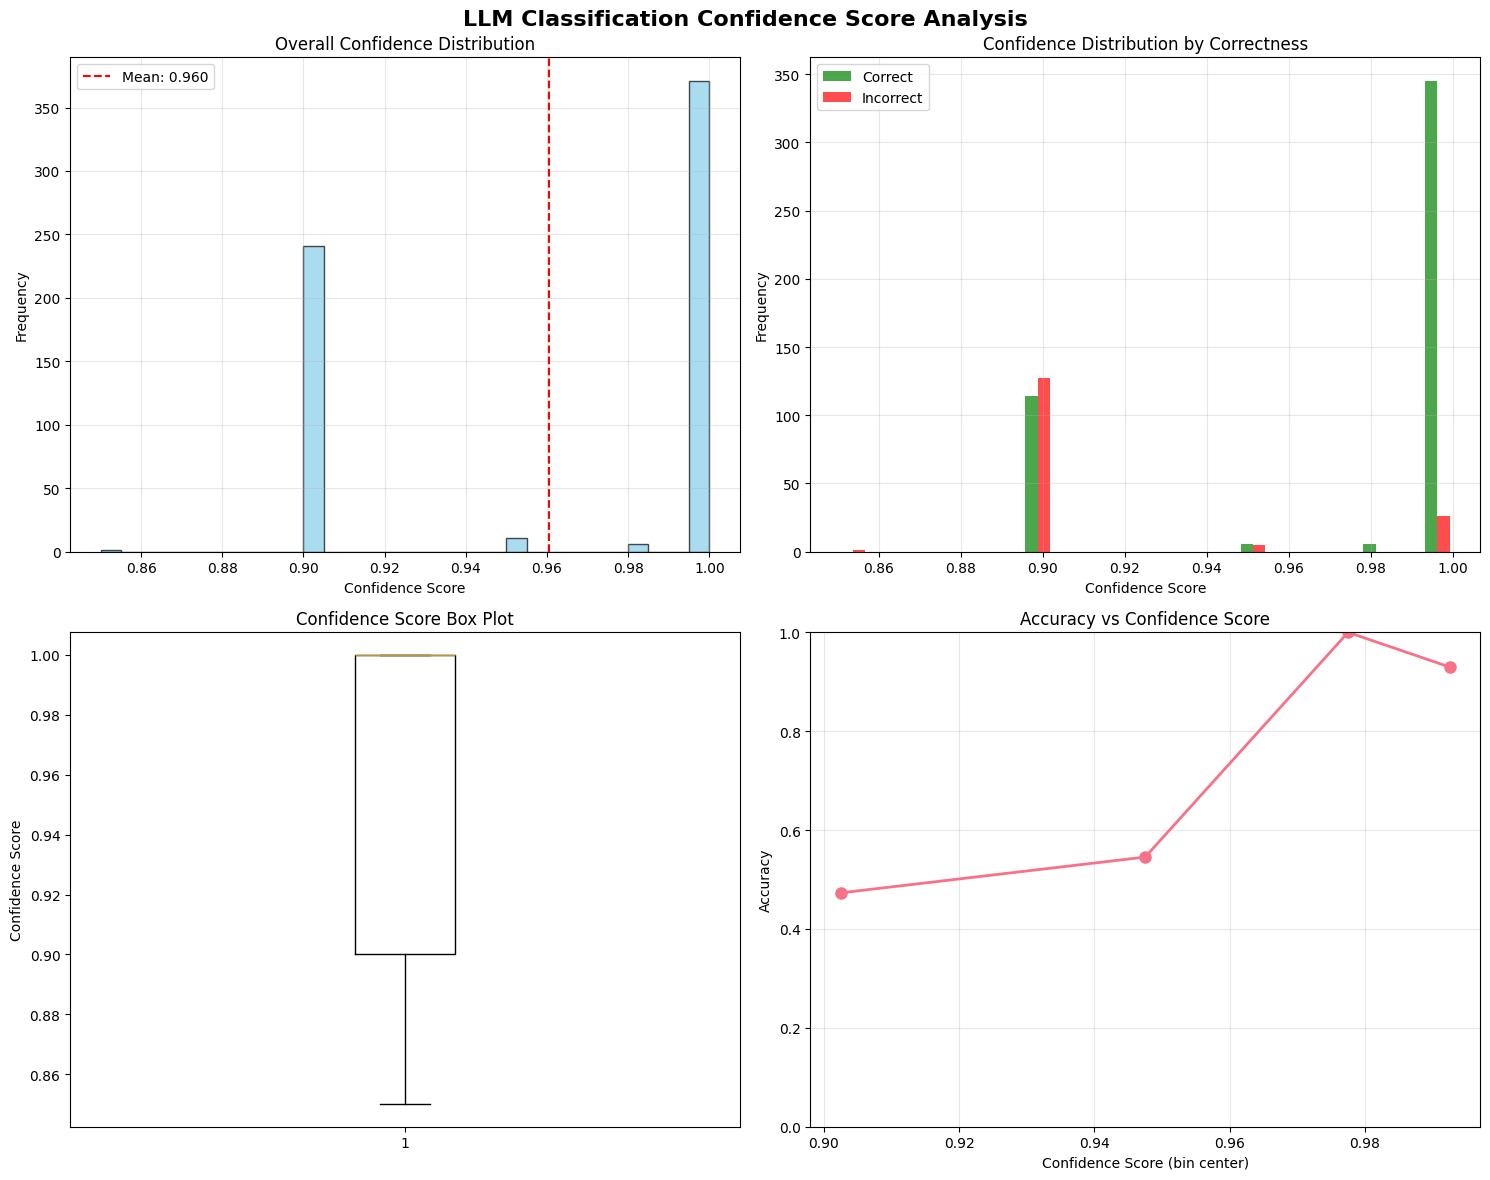

In [12]:
### 6.1 Confidence Score Distributions

if 'df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LLM Classification Confidence Score Analysis', fontsize=16, fontweight='bold')
    
    # 1. Overall confidence distribution
    axes[0, 0].hist(df['confidence_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(df['confidence_score'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {df["confidence_score"].mean():.3f}')
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Overall Confidence Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Confidence by correctness
    correct_conf = df[df['is_correct']]['confidence_score']
    incorrect_conf = df[~df['is_correct']]['confidence_score']
    
    axes[0, 1].hist([correct_conf, incorrect_conf], bins=20, alpha=0.7, 
                    label=['Correct', 'Incorrect'], color=['green', 'red'])
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Confidence Distribution by Correctness')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot by model
    if df['model'].nunique() > 1:
        df.boxplot(column='confidence_score', by='model', ax=axes[1, 0])
        axes[1, 0].set_title('Confidence Distribution by Model')
        axes[1, 0].set_xlabel('Model')
        axes[1, 0].set_ylabel('Confidence Score')
    else:
        axes[1, 0].boxplot(df['confidence_score'])
        axes[1, 0].set_title('Confidence Score Box Plot')
        axes[1, 0].set_ylabel('Confidence Score')
    
    # 4. Confidence vs Accuracy correlation
    # Create confidence bins
    confidence_bins = pd.cut(df['confidence_score'], bins=10)
    accuracy_by_conf = df.groupby(confidence_bins)['is_correct'].agg(['mean', 'count'])
    
    # Only plot bins with sufficient data
    mask = accuracy_by_conf['count'] >= 5
    filtered_accuracy = accuracy_by_conf[mask]
    
    if len(filtered_accuracy) > 0:
        bin_centers = [interval.mid for interval in filtered_accuracy.index]
        axes[1, 1].plot(bin_centers, filtered_accuracy['mean'], 'o-', linewidth=2, markersize=8)
        axes[1, 1].set_xlabel('Confidence Score (bin center)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Accuracy vs Confidence Score')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
else:
    print("Data not available for visualization.")

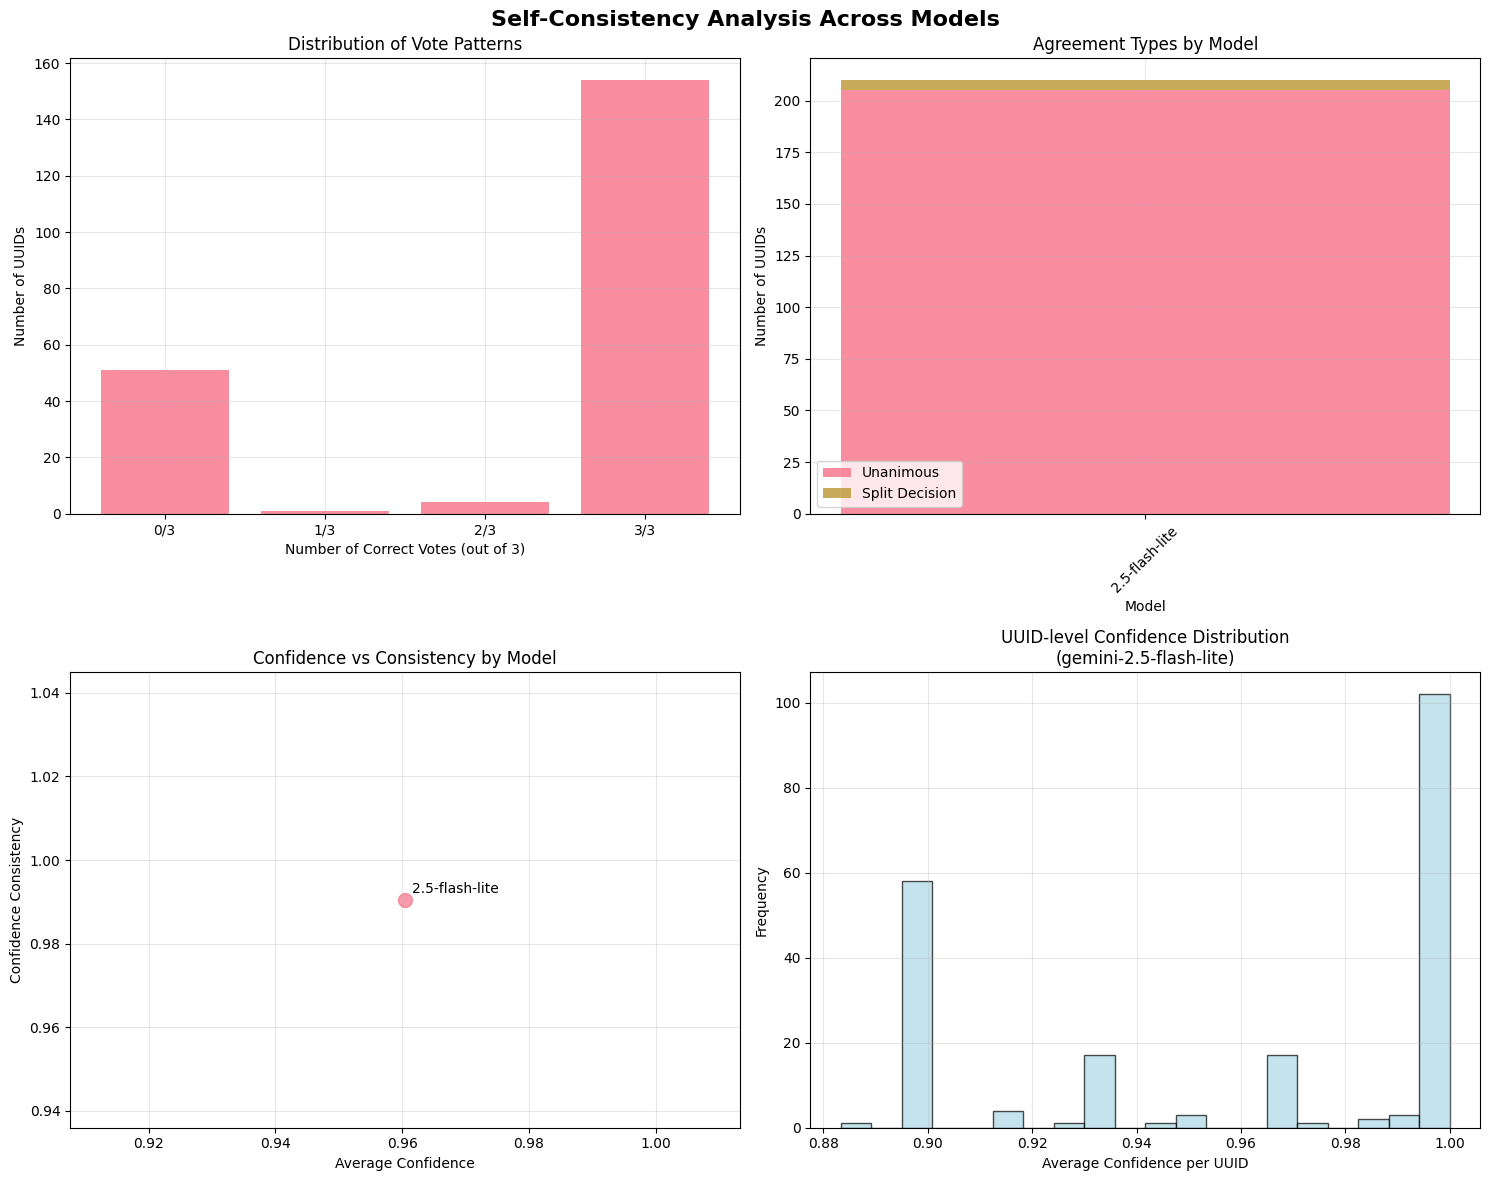

In [13]:
### 6.2 Self-Consistency Visualization

if 'df' in locals() and 'consistency_results' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Self-Consistency Analysis Across Models', fontsize=16, fontweight='bold')
    
    # Prepare data for visualization
    models = list(consistency_results.keys())
    
    if len(models) > 0:
        # 1. Agreement patterns
        agreement_data = []
        for model in models:
            details = consistency_results[model]['details']
            agreement_counts = details['votes_correct'].value_counts().reindex([0, 1, 2, 3], fill_value=0)
            agreement_data.append(agreement_counts.values)
        
        x = np.arange(4)
        width = 0.35 if len(models) > 1 else 0.8
        
        for i, model in enumerate(models):
            offset = (i - len(models)/2 + 0.5) * width if len(models) > 1 else 0
            axes[0, 0].bar(x + offset, agreement_data[i], width, 
                          label=model, alpha=0.8)
        
        axes[0, 0].set_xlabel('Number of Correct Votes (out of 3)')
        axes[0, 0].set_ylabel('Number of UUIDs')
        axes[0, 0].set_title('Distribution of Vote Patterns')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(['0/3', '1/3', '2/3', '3/3'])
        if len(models) > 1:
            axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Unanimous vs Split decisions
        unanimous_data = []
        split_data = []
        for model in models:
            stats = consistency_results[model]['stats']
            unanimous_data.append(stats['unanimous_agreement'])
            split_data.append(stats['split_decisions'])
        
        x = np.arange(len(models))
        axes[0, 1].bar(x, unanimous_data, width=0.4, label='Unanimous', alpha=0.8)
        axes[0, 1].bar(x, split_data, width=0.4, bottom=unanimous_data, 
                      label='Split Decision', alpha=0.8)
        axes[0, 1].set_xlabel('Model')
        axes[0, 1].set_ylabel('Number of UUIDs')
        axes[0, 1].set_title('Agreement Types by Model')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels([model.replace('gemini-', '') for model in models], rotation=45)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Confidence consistency
        conf_consistency_data = [consistency_results[model]['stats']['confidence_consistency'] 
                               for model in models]
        avg_confidence_data = [consistency_results[model]['stats']['avg_confidence'] 
                             for model in models]
        
        axes[1, 0].scatter(avg_confidence_data, conf_consistency_data, s=100, alpha=0.7)
        for i, model in enumerate(models):
            axes[1, 0].annotate(model.replace('gemini-', ''), 
                              (avg_confidence_data[i], conf_consistency_data[i]),
                              xytext=(5, 5), textcoords='offset points')
        axes[1, 0].set_xlabel('Average Confidence')
        axes[1, 0].set_ylabel('Confidence Consistency')
        axes[1, 0].set_title('Confidence vs Consistency by Model')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Performance summary
        if len(models) > 0:
            # Get first model details for histogram
            first_model_details = consistency_results[models[0]]['details']
            axes[1, 1].hist(first_model_details['confidence_mean'], bins=20, alpha=0.7, 
                           color='lightblue', edgecolor='black')
            axes[1, 1].set_xlabel('Average Confidence per UUID')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title(f'UUID-level Confidence Distribution\n({models[0]})')
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Consistency results not available for visualization.")

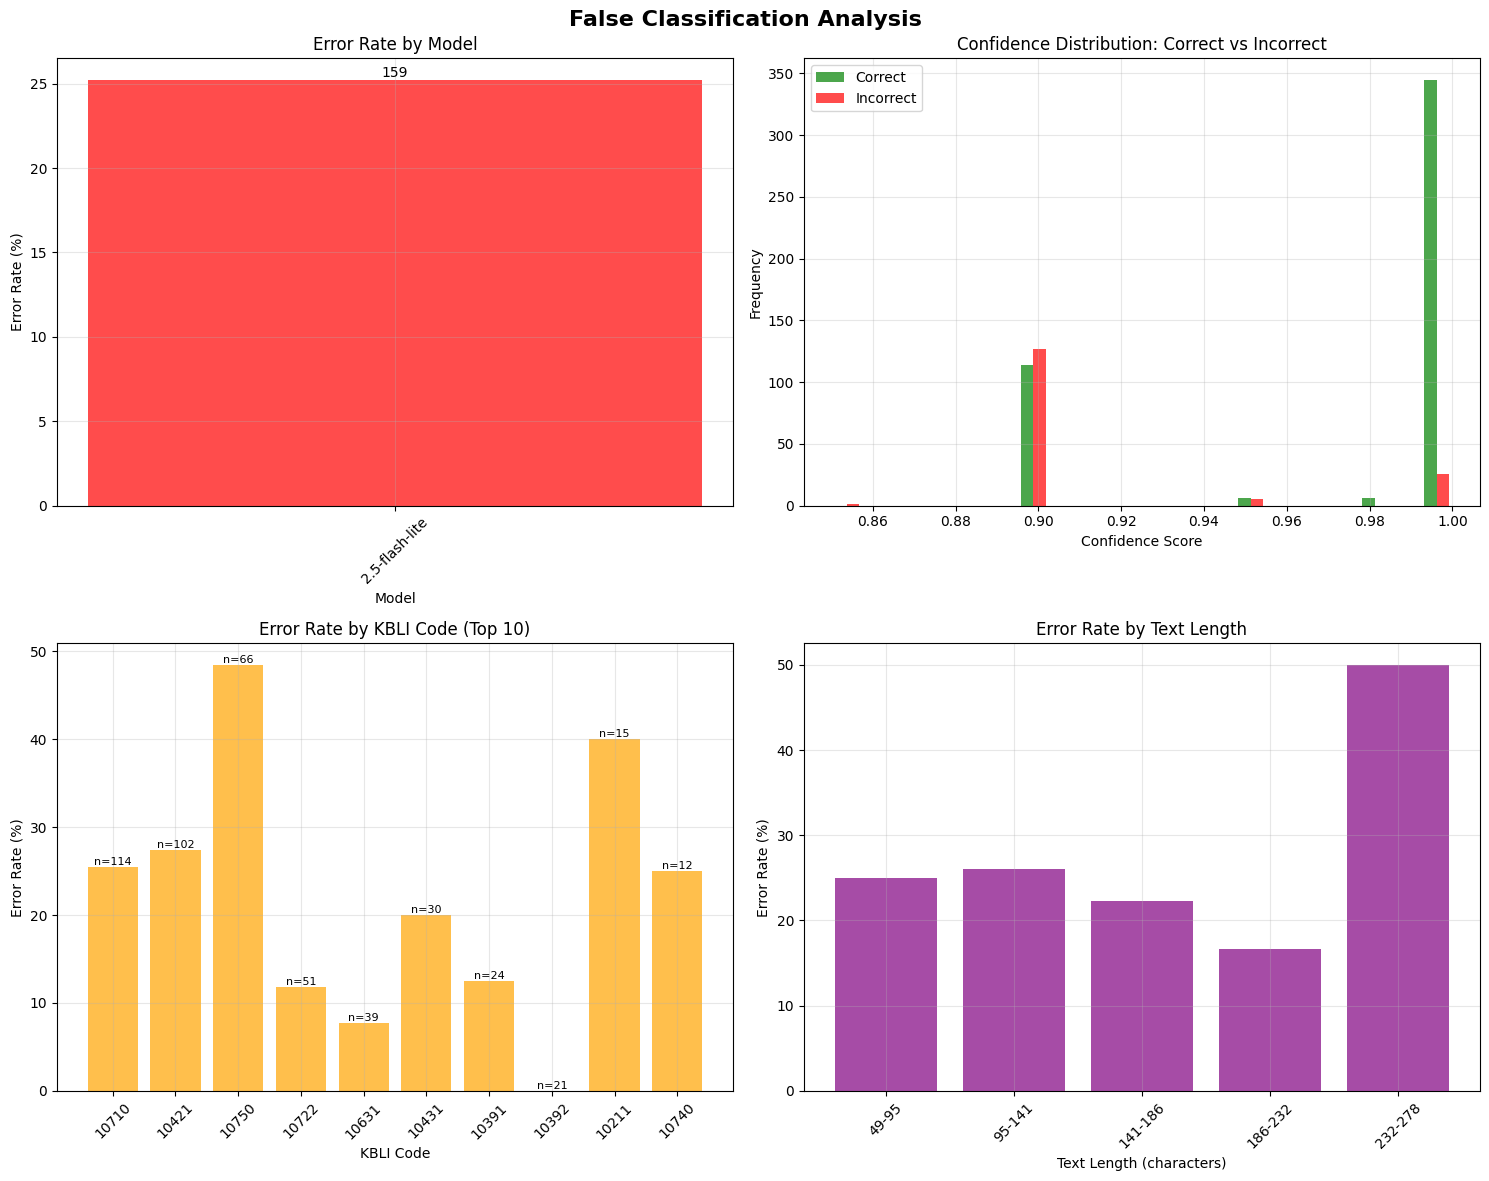


ERROR CONSISTENCY ANALYSIS


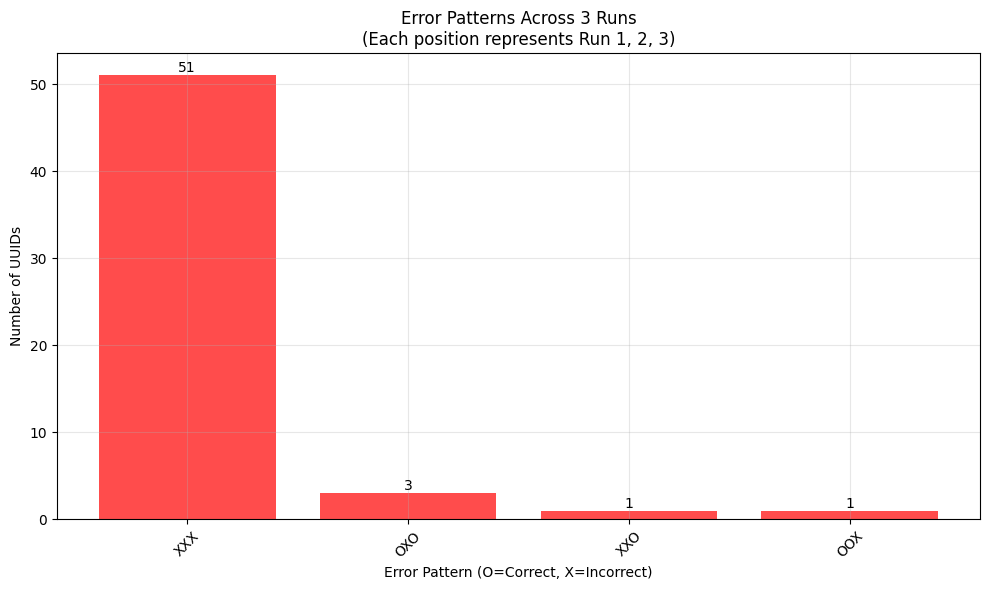

Error pattern distribution:
  XXX: 51 UUIDs
  OXO: 3 UUIDs
  XXO: 1 UUIDs
  OOX: 1 UUIDs


In [14]:
### 6.3 False Classification Visualizations

if 'df' in locals():
    false_classifications = df[df['is_correct'] == False].copy()
    
    if len(false_classifications) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('False Classification Analysis', fontsize=16, fontweight='bold')
        
        # 1. Error rate by model
        model_error_rates = df.groupby('model')['is_correct'].agg(['count', 'mean'])
        model_error_rates['error_rate'] = (1 - model_error_rates['mean']) * 100
        model_error_rates['error_count'] = model_error_rates['count'] * (1 - model_error_rates['mean'])
        
        model_names = [name.replace('gemini-', '') for name in model_error_rates.index]
        axes[0, 0].bar(model_names, model_error_rates['error_rate'], color='red', alpha=0.7)
        axes[0, 0].set_xlabel('Model')
        axes[0, 0].set_ylabel('Error Rate (%)')
        axes[0, 0].set_title('Error Rate by Model')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add error count annotations
        for i, (model, rate) in enumerate(zip(model_names, model_error_rates['error_rate'])):
            error_count = int(model_error_rates['error_count'].iloc[i])
            axes[0, 0].annotate(f'{error_count}', (i, rate), ha='center', va='bottom')
        
        # 2. Confidence distribution for false vs true classifications
        true_conf = df[df['is_correct']]['confidence_score']
        false_conf = false_classifications['confidence_score']
        
        axes[0, 1].hist([true_conf, false_conf], bins=20, alpha=0.7, 
                       label=['Correct', 'Incorrect'], color=['green', 'red'])
        axes[0, 1].set_xlabel('Confidence Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Confidence Distribution: Correct vs Incorrect')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Error rate by KBLI code (top 10 codes by frequency)
        top_kbli_codes = df['kbli_code'].value_counts().head(10).index
        kbli_error_data = []
        
        for code in top_kbli_codes:
            code_data = df[df['kbli_code'] == code]
            error_rate = (1 - code_data['is_correct'].mean()) * 100
            total_count = len(code_data)
            kbli_error_data.append({'code': code, 'error_rate': error_rate, 'count': total_count})
        
        kbli_df = pd.DataFrame(kbli_error_data)
        bars = axes[1, 0].bar(range(len(kbli_df)), kbli_df['error_rate'], color='orange', alpha=0.7)
        axes[1, 0].set_xlabel('KBLI Code')
        axes[1, 0].set_ylabel('Error Rate (%)')
        axes[1, 0].set_title('Error Rate by KBLI Code (Top 10)')
        axes[1, 0].set_xticks(range(len(kbli_df)))
        axes[1, 0].set_xticklabels(kbli_df['code'], rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add count annotations
        for i, (bar, count) in enumerate(zip(bars, kbli_df['count'])):
            axes[1, 0].annotate(f'n={count}', (i, bar.get_height()), ha='center', va='bottom', fontsize=8)
        
        # 4. Text length vs accuracy
        if 'text_length' in df.columns:
            # Create text length bins
            df['length_bin'] = pd.cut(df['text_length'], bins=5)
            length_accuracy = df.groupby('length_bin')['is_correct'].agg(['count', 'mean'])
            length_accuracy['error_rate'] = (1 - length_accuracy['mean']) * 100
            
            bin_labels = [f'{int(interval.left)}-{int(interval.right)}' for interval in length_accuracy.index]
            axes[1, 1].bar(range(len(length_accuracy)), length_accuracy['error_rate'], 
                          color='purple', alpha=0.7)
            axes[1, 1].set_xlabel('Text Length (characters)')
            axes[1, 1].set_ylabel('Error Rate (%)')
            axes[1, 1].set_title('Error Rate by Text Length')
            axes[1, 1].set_xticks(range(len(length_accuracy)))
            axes[1, 1].set_xticklabels(bin_labels, rotation=45)
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Text length data\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Text Length Analysis')
        
        plt.tight_layout()
        plt.show()
        
        # Additional visualization: Error patterns over runs
        if df['run_id'].nunique() == 3:
            print("\n" + "="*50)
            print("ERROR CONSISTENCY ANALYSIS")
            print("="*50)
            
            # Analyze error patterns across runs
            error_patterns = []
            for model in df['model'].unique():
                model_data = df[df['model'] == model]
                
                for uuid in model_data['uuid'].unique():
                    uuid_data = model_data[model_data['uuid'] == uuid]
                    
                    if len(uuid_data) == 3:
                        error_pattern = tuple(~uuid_data.sort_values('run_id')['is_correct'])
                        error_count = sum(error_pattern)
                        
                        if error_count > 0:  # At least one error
                            error_patterns.append({
                                'model': model,
                                'uuid': uuid,
                                'pattern': error_pattern,
                                'error_count': error_count,
                                'pattern_str': ''.join(['X' if x else 'O' for x in error_pattern])
                            })
            
            if error_patterns:
                error_df = pd.DataFrame(error_patterns)
                pattern_counts = error_df['pattern_str'].value_counts()
                
                plt.figure(figsize=(10, 6))
                plt.bar(pattern_counts.index, pattern_counts.values, color='red', alpha=0.7)
                plt.xlabel('Error Pattern (O=Correct, X=Incorrect)')
                plt.ylabel('Number of UUIDs')
                plt.title('Error Patterns Across 3 Runs\n(Each position represents Run 1, 2, 3)')
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                
                # Add count annotations
                for i, (pattern, count) in enumerate(pattern_counts.items()):
                    plt.annotate(f'{count}', (i, count), ha='center', va='bottom')
                
                plt.tight_layout()
                plt.show()
                
                print(f"Error pattern distribution:")
                for pattern, count in pattern_counts.items():
                    print(f"  {pattern}: {count} UUIDs")
    
    else:
        print("No false classifications found for visualization.")
        plt.figure(figsize=(8, 6))
        plt.text(0.5, 0.5, 'No False Classifications Found\nAll predictions appear to be correct!', 
                ha='center', va='center', fontsize=16, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('False Classification Analysis', fontsize=16, fontweight='bold')
        plt.show()
else:
    print("Data not available for false classification visualization.")

In [15]:
### 6.3 Interactive Visualizations with Plotly

if 'df' in locals():
    print("Creating interactive visualizations...")
    
    # 1. Interactive confidence distribution by model and correctness
    fig_conf = px.histogram(df, x='confidence_score', color='is_correct', 
                           facet_col='model' if df['model'].nunique() > 1 else None,
                           title='Interactive Confidence Distribution',
                           labels={'is_correct': 'Classification Result',
                                  'confidence_score': 'Confidence Score'},
                           nbins=25)
    fig_conf.update_layout(height=500)
    fig_conf.show()
    
    # 2. KBLI Code performance analysis (top 15 codes)
    top_codes = df['kbli_code'].value_counts().head(15).index
    kbli_summary = df[df['kbli_code'].isin(top_codes)].groupby('kbli_code').agg({
        'is_correct': ['count', 'mean'],
        'confidence_score': 'mean'
    }).round(3)
    
    kbli_summary.columns = ['Total_Predictions', 'Accuracy', 'Avg_Confidence']
    kbli_summary = kbli_summary.reset_index()
    
    fig_kbli = px.scatter(kbli_summary, x='Avg_Confidence', y='Accuracy', 
                         size='Total_Predictions', hover_data=['kbli_code'],
                         title='KBLI Code Performance: Accuracy vs Confidence',
                         labels={'Avg_Confidence': 'Average Confidence Score',
                                'Accuracy': 'Classification Accuracy'})
    fig_kbli.update_layout(height=500)
    fig_kbli.show()
    
    # 3. Time series analysis (if timestamp available)
    if 'timestamp' in df.columns and df['timestamp'].notna().sum() > 0:
        df_time = df.copy()
        df_time['hour'] = df_time['timestamp'].dt.hour
        df_time['date'] = df_time['timestamp'].dt.date
        
        # Performance over time
        daily_performance = df_time.groupby('date').agg({
            'is_correct': 'mean',
            'confidence_score': 'mean',
            'uuid': 'count'
        }).reset_index()
        daily_performance.columns = ['Date', 'Accuracy', 'Avg_Confidence', 'Count']
        
        fig_time = make_subplots(specs=[[{"secondary_y": True}]])
        
        fig_time.add_trace(
            go.Scatter(x=daily_performance['Date'], y=daily_performance['Accuracy'],
                      name='Accuracy', line=dict(color='blue')),
            secondary_y=False,
        )
        
        fig_time.add_trace(
            go.Scatter(x=daily_performance['Date'], y=daily_performance['Avg_Confidence'],
                      name='Avg Confidence', line=dict(color='red')),
            secondary_y=True,
        )
        
        fig_time.update_xaxes(title_text="Date")
        fig_time.update_yaxes(title_text="Accuracy", secondary_y=False)
        fig_time.update_yaxes(title_text="Average Confidence", secondary_y=True)
        fig_time.update_layout(title_text="Performance Over Time", height=500)
        
        fig_time.show()
    
    print("Interactive visualizations completed!")
else:
    print("Data not available for interactive visualization.")

Creating interactive visualizations...


Interactive visualizations completed!


In [16]:
### 6.4 Interactive False Classification Analysis

if 'df' in locals():
    false_classifications = df[df['is_correct'] == False].copy()
    
    if len(false_classifications) > 0:
        print("Creating interactive false classification visualizations...")
        
        # 1. Interactive scatter plot: Confidence vs Text Length for false classifications
        false_classifications['text_length'] = false_classifications['text'].str.len()
        
        fig_scatter = px.scatter(false_classifications, 
                               x='text_length', 
                               y='confidence_score',
                               color='model',
                               size='run_id',
                               hover_data=['uuid', 'kbli_code', 'text'],
                               title='False Classifications: Confidence vs Text Length',
                               labels={'text_length': 'Text Length (characters)',
                                      'confidence_score': 'Confidence Score'})
        fig_scatter.update_layout(height=500)
        fig_scatter.show()
        
        # 2. Interactive error rate analysis by KBLI code
        kbli_analysis = df.groupby('kbli_code').agg({
            'is_correct': ['count', 'sum', 'mean'],
            'confidence_score': 'mean'
        }).round(3)
        kbli_analysis.columns = ['Total_Count', 'Correct_Count', 'Accuracy', 'Avg_Confidence']
        kbli_analysis['Error_Rate'] = (1 - kbli_analysis['Accuracy']) * 100
        kbli_analysis['Error_Count'] = kbli_analysis['Total_Count'] - kbli_analysis['Correct_Count']
        kbli_analysis = kbli_analysis.reset_index()
        
        # Filter codes with at least 2 predictions for meaningful analysis
        kbli_filtered = kbli_analysis[kbli_analysis['Total_Count'] >= 2]
        
        fig_kbli_error = px.scatter(kbli_filtered, 
                                  x='Avg_Confidence', 
                                  y='Error_Rate',
                                  size='Total_Count',
                                  hover_data=['kbli_code', 'Error_Count'],
                                  title='KBLI Code Analysis: Error Rate vs Average Confidence',
                                  labels={'Avg_Confidence': 'Average Confidence Score',
                                         'Error_Rate': 'Error Rate (%)'})
        fig_kbli_error.update_layout(height=500)
        fig_kbli_error.show()
        
        # 3. Model comparison for false classifications
        model_comparison = df.groupby(['model', 'is_correct']).size().unstack(fill_value=0)
        model_comparison['Total'] = model_comparison.sum(axis=1)
        model_comparison['Error_Rate'] = (model_comparison[False] / model_comparison['Total'] * 100).round(2)
        model_comparison = model_comparison.reset_index()
        
        fig_model = px.bar(model_comparison, 
                          x='model', 
                          y=[True, False],
                          title='Model Performance Comparison: Correct vs Incorrect Classifications',
                          labels={'value': 'Number of Classifications', 'variable': 'Classification Result'},
                          color_discrete_map={True: 'green', False: 'red'})
        fig_model.update_layout(height=500)
        fig_model.show()
        
        # 4. Temporal analysis of false classifications (if timestamp available)
        if 'timestamp' in df.columns and df['timestamp'].notna().sum() > 0:
            df_temp = df.copy()
            df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
            df_temp['hour'] = df_temp['timestamp'].dt.hour
            df_temp['date'] = df_temp['timestamp'].dt.date
            
            # Hourly error analysis
            hourly_analysis = df_temp.groupby('hour')['is_correct'].agg(['count', 'mean']).reset_index()
            hourly_analysis['error_rate'] = (1 - hourly_analysis['mean']) * 100
            hourly_analysis['error_count'] = hourly_analysis['count'] * (1 - hourly_analysis['mean'])
            
            fig_temporal = px.line(hourly_analysis, 
                                 x='hour', 
                                 y='error_rate',
                                 markers=True,
                                 title='Error Rate by Hour of Day',
                                 labels={'hour': 'Hour of Day', 'error_rate': 'Error Rate (%)'})
            
            # Add hover information
            fig_temporal.update_traces(
                hovertemplate='<b>Hour %{x}</b><br>Error Rate: %{y:.1f}%<br>Total Predictions: %{customdata[0]}<br>Errors: %{customdata[1]:.0f}<extra></extra>',
                customdata=hourly_analysis[['count', 'error_count']].values
            )
            fig_temporal.update_layout(height=400)
            fig_temporal.show()
        
        # 5. Word cloud analysis for false classifications (if enough data)
        if len(false_classifications) >= 10:
            print("\nGenerating word frequency analysis for false classifications...")
            
            # Combine all false classification texts
            false_text_combined = ' '.join(false_classifications['text'].astype(str).str.lower())
            
            # Basic word frequency analysis
            import re
            words = re.findall(r'\b\w+\b', false_text_combined)
            word_freq = pd.Series(words).value_counts()
            
            # Filter out very short words and get top 20
            significant_words = word_freq[word_freq.index.str.len() > 3].head(20)
            
            fig_words = px.bar(x=significant_words.index, 
                             y=significant_words.values,
                             title='Most Common Words in False Classifications',
                             labels={'x': 'Words', 'y': 'Frequency'})
            fig_words.update_layout(height=400, xaxis_tickangle=-45)
            fig_words.show()
        
        print("Interactive false classification analysis completed!")
        
    else:
        print("No false classifications found for interactive analysis.")
        
        # Show a summary visualization instead
        accuracy_by_model = df.groupby('model')['is_correct'].mean() * 100
        
        fig_summary = px.bar(x=accuracy_by_model.index, 
                           y=accuracy_by_model.values,
                           title='Model Accuracy - No False Classifications Found!',
                           labels={'x': 'Model', 'y': 'Accuracy (%)'},
                           color=accuracy_by_model.values,
                           color_continuous_scale='Greens')
        fig_summary.update_layout(height=400, showlegend=False)
        fig_summary.show()
        
else:
    print("Data not available for interactive false classification analysis.")

Creating interactive false classification visualizations...



Generating word frequency analysis for false classifications...


Interactive false classification analysis completed!


## 7. Export Results

Save processed data, analysis results, and summary statistics for further use and reporting.

In [ ]:
### 7.1 Export Processed Data and Analysis Results

if 'df' in locals():
    # Improved dataset detection function
    def detect_dataset_name(df):
        """
        Detect dataset name from source files with better logic for multiple models.
        """
        if 'source_file' not in df.columns or df['source_file'].isna().all():
            return "unknown_dataset"
        
        # Get all unique source files
        source_files = df['source_file'].dropna().unique()
        print(f"Analyzing {len(source_files)} source files for dataset detection:")
        for file in source_files:
            print(f"  - {file}")
        
        # Extract potential dataset names from all files
        potential_names = []
        
        for file in source_files:
            file_lower = file.lower()
            
            # Check for common dataset patterns first
            if 'mini_test' in file_lower:
                potential_names.append('mini_test')
            elif 'full_test' in file_lower:
                potential_names.append('full_test')
            elif 'pilot' in file_lower and not any(model in file_lower for model in ['gemini', 'claude', 'gpt']):
                potential_names.append('pilot_data')
            else:
                # Extract name by removing model names and extensions
                name_part = file.replace('.jsonl', '')
                
                # Common model patterns to identify and remove
                model_patterns = ['gemini-', 'claude-', 'gpt-', 'llama-', 'anthropic-']
                model_found = False
                
                for pattern in model_patterns:
                    if pattern in name_part.lower():
                        # Split by underscores and find model component
                        parts = name_part.split('_')
                        model_index = -1
                        
                        for i, part in enumerate(parts):
                            if any(mp.replace('-', '') in part.lower() for mp in model_patterns):
                                model_index = i
                                break
                        
                        if model_index > 0:
                            # Take everything before the model part
                            dataset_part = '_'.join(parts[:model_index])
                            potential_names.append(dataset_part)
                            model_found = True
                            break
                
                if not model_found:
                    # Fallback: use filename without extension, but try to clean it
                    parts = name_part.split('_')
                    # Remove common suffixes like 'results', 'output', etc.
                    clean_parts = [p for p in parts if p.lower() not in ['results', 'output', 'data', 'final']]
                    dataset_part = '_'.join(clean_parts) if clean_parts else parts[0] if parts else "dataset"
                    potential_names.append(dataset_part)
        
        # Return most common dataset name, or first if all unique
        if potential_names:
            from collections import Counter
            name_counts = Counter(potential_names)
            most_common_name = name_counts.most_common(1)[0][0]
            
            if len(name_counts) > 1:
                print(f"Dataset name candidates found: {dict(name_counts)}")
                print(f"Selected most common dataset name: '{most_common_name}'")
            else:
                print(f"Consistent dataset name detected: '{most_common_name}'")
            
            return most_common_name
        
        return "unknown_dataset"
    
    # Detect dataset name using improved logic
    dataset_name = detect_dataset_name(df)
    
    # Create organized export directory structure
    base_export_dir = Path("../reports/analysis_results/pilot")
    export_dir = base_export_dir / dataset_name
    export_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("\n=== EXPORTING RESULTS ===")
    print(f"Final dataset name: {dataset_name}")
    print(f"Export directory: {export_dir}")
    print(f"Models in dataset: {', '.join(sorted(df['model'].unique()))}")
    print(f"Total source files: {df['source_file'].nunique()}")
    
    print("=== EXPORTING RESULTS ===")
    
    # 1. Export cleaned dataset
    clean_data_file = export_dir / f"llm_results_cleaned_{timestamp}.csv"
    df.to_csv(clean_data_file, index=False)
    print(f"Cleaned dataset exported: {clean_data_file}")
    
    # 2. Export self-consistency results
    if 'consistency_results' in locals():
        for model, result in consistency_results.items():
            consistency_file = export_dir / f"consistency_{model.replace('-', '_')}_{timestamp}.csv"
            result['details'].to_csv(consistency_file, index=False)
            print(f"Consistency analysis exported: {consistency_file}")
    
    # 3. Export summary statistics
    summary_stats = {
        'analysis_timestamp': datetime.now().isoformat(),
        'total_records': len(df),
        'unique_uuids': df['uuid'].nunique(),
        'unique_models': df['model'].nunique(),
        'unique_kbli_codes': df['kbli_code'].nunique(),
        'overall_accuracy': df['is_correct'].mean(),
        'average_confidence': df['confidence_score'].mean(),
        'confidence_std': df['confidence_score'].std(),
        'model_performance': {}
    }
    
    # Add per-model statistics
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        summary_stats['model_performance'][model] = {
            'records': len(model_data),
            'unique_uuids': model_data['uuid'].nunique(),
            'accuracy': model_data['is_correct'].mean(),
            'avg_confidence': model_data['confidence_score'].mean(),
            'confidence_std': model_data['confidence_score'].std()
        }
    
    # Save summary as JSON
    summary_file = export_dir / f"analysis_summary_{timestamp}.json"
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False, default=str)
    print(f"Summary statistics exported: {summary_file}")
    
    # 4. Export voting results (majority vote per UUID)
    if df['run_id'].nunique() == 3:  # If we have the expected 3 runs
        voting_results = []
        
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            
            for uuid in model_data['uuid'].unique():
                uuid_data = model_data[model_data['uuid'] == uuid]
                
                if len(uuid_data) == 3:
                    votes = uuid_data['is_correct'].tolist()
                    confidences = uuid_data['confidence_score'].tolist()
                    
                    majority_vote = sum(votes) >= 2
                    vote_count = sum(votes)
                    unanimous = vote_count in [0, 3]
                    
                    voting_results.append({
                        'uuid': uuid,
                        'model': model,
                        'text': uuid_data.iloc[0]['text'],
                        'kbli_code': uuid_data.iloc[0]['kbli_code'],
                        'votes_correct': vote_count,
                        'majority_vote': majority_vote,
                        'unanimous': unanimous,
                        'confidence_mean': np.mean(confidences),
                        'confidence_std': np.std(confidences),
                        'individual_votes': votes,
                        'individual_confidences': confidences
                    })
        
        if voting_results:
            voting_df = pd.DataFrame(voting_results)
            voting_file = export_dir / f"voting_results_{timestamp}.csv"
            voting_df.to_csv(voting_file, index=False)
            print(f"Voting results exported: {voting_file}")
    
    # 5. Export KBLI code performance
    kbli_performance = df.groupby('kbli_code').agg({
        'is_correct': ['count', 'mean'],
        'confidence_score': ['mean', 'std'],
        'uuid': 'nunique'
    }).round(3)
    
    kbli_performance.columns = ['Total_Predictions', 'Accuracy', 'Avg_Confidence', 'Confidence_Std', 'Unique_UUIDs']
    kbli_performance = kbli_performance.reset_index()
    
    kbli_file = export_dir / f"kbli_performance_{timestamp}.csv"
    kbli_performance.to_csv(kbli_file, index=False)
    print(f"KBLI performance exported: {kbli_file}")
    
    print(f"\n=== EXPORT COMPLETED ===")
    print(f"All files saved to: {export_dir}")
    print(f"Export timestamp: {timestamp}")
    
else:
    print("No data available for export.")

=== EXPORTING RESULTS ===
Cleaned dataset exported: ..\reports\analysis_results\llm_results_cleaned_20250730_114806.csv
Consistency analysis exported: ..\reports\analysis_results\consistency_gemini_2.5_flash_lite_20250730_114806.csv
Summary statistics exported: ..\reports\analysis_results\analysis_summary_20250730_114806.json
Voting results exported: ..\reports\analysis_results\voting_results_20250730_114806.csv
KBLI performance exported: ..\reports\analysis_results\kbli_performance_20250730_114806.csv

=== EXPORT COMPLETED ===
All files saved to: ..\reports\analysis_results
Export timestamp: 20250730_114806
Cleaned dataset exported: ..\reports\analysis_results\llm_results_cleaned_20250730_114806.csv
Consistency analysis exported: ..\reports\analysis_results\consistency_gemini_2.5_flash_lite_20250730_114806.csv
Summary statistics exported: ..\reports\analysis_results\analysis_summary_20250730_114806.json
Voting results exported: ..\reports\analysis_results\voting_results_20250730_11480

In [18]:
    # 6. Export False Classification Analysis
    false_classifications = df[df['is_correct'] == False].copy()
    
    if len(false_classifications) > 0:
        # Export detailed false classification records
        false_detail_file = export_dir / f"false_classifications_detailed_{timestamp}.csv"
        
        # Add text length for analysis
        false_classifications['text_length'] = false_classifications['text'].str.len()
        
        # Select relevant columns for export
        false_export_cols = ['uuid', 'text', 'kbli_code', 'run_id', 'model', 'timestamp', 
                           'confidence_score', 'text_length']
        
        # Add reasoning and alternatives if available
        if 'reasoning' in false_classifications.columns:
            false_export_cols.append('reasoning')
        if 'alternative_codes' in false_classifications.columns:
            false_export_cols.append('alternative_codes')
        if 'alternative_reasoning' in false_classifications.columns:
            false_export_cols.append('alternative_reasoning')
        
        false_classifications[false_export_cols].to_csv(false_detail_file, index=False)
        print(f"False classifications details exported: {false_detail_file}")
        
        # Export false classification summary by model
        false_summary_by_model = df.groupby('model').agg({
            'is_correct': ['count', 'sum', 'mean'],
            'confidence_score': 'mean'
        }).round(3)
        false_summary_by_model.columns = ['Total_Predictions', 'Correct_Count', 'Accuracy', 'Avg_Confidence']
        false_summary_by_model['Error_Count'] = false_summary_by_model['Total_Predictions'] - false_summary_by_model['Correct_Count']
        false_summary_by_model['Error_Rate'] = (1 - false_summary_by_model['Accuracy']) * 100
        false_summary_by_model = false_summary_by_model.reset_index()
        
        false_summary_file = export_dir / f"error_analysis_by_model_{timestamp}.csv"
        false_summary_by_model.to_csv(false_summary_file, index=False)
        print(f"Error analysis by model exported: {false_summary_file}")
        
        # Export error analysis by KBLI code
        kbli_error_analysis = df.groupby('kbli_code').agg({
            'is_correct': ['count', 'sum', 'mean'],
            'confidence_score': 'mean'
        }).round(3)
        kbli_error_analysis.columns = ['Total_Predictions', 'Correct_Count', 'Accuracy', 'Avg_Confidence']
        kbli_error_analysis['Error_Count'] = kbli_error_analysis['Total_Predictions'] - kbli_error_analysis['Correct_Count']
        kbli_error_analysis['Error_Rate'] = (1 - kbli_error_analysis['Accuracy']) * 100
        kbli_error_analysis = kbli_error_analysis.reset_index()
        
        # Sort by error rate (descending) for problematic codes
        kbli_error_analysis = kbli_error_analysis.sort_values('Error_Rate', ascending=False)
        
        kbli_error_file = export_dir / f"error_analysis_by_kbli_{timestamp}.csv"
        kbli_error_analysis.to_csv(kbli_error_file, index=False)
        print(f"Error analysis by KBLI code exported: {kbli_error_file}")
        
        # Export error consistency analysis (if 3 runs available)
        if df['run_id'].nunique() == 3:
            error_consistency = []
            
            for model in df['model'].unique():
                model_data = df[df['model'] == model]
                
                for uuid in model_data['uuid'].unique():
                    uuid_data = model_data[model_data['uuid'] == uuid]
                    
                    if len(uuid_data) == 3:
                        errors = (~uuid_data.sort_values('run_id')['is_correct']).tolist()
                        error_count = sum(errors)
                        
                        if error_count > 0:  # At least one error
                            error_consistency.append({
                                'uuid': uuid,
                                'model': model,
                                'text': uuid_data.iloc[0]['text'],
                                'kbli_code': uuid_data.iloc[0]['kbli_code'],
                                'run1_error': errors[0],
                                'run2_error': errors[1],
                                'run3_error': errors[2],
                                'total_errors': error_count,
                                'error_pattern': ''.join(['X' if x else 'O' for x in errors]),
                                'avg_confidence': uuid_data['confidence_score'].mean(),
                                'confidence_std': uuid_data['confidence_score'].std()
                            })
            
            if error_consistency:
                error_consistency_df = pd.DataFrame(error_consistency)
                consistency_file = export_dir / f"error_consistency_analysis_{timestamp}.csv"
                error_consistency_df.to_csv(consistency_file, index=False)
                print(f"Error consistency analysis exported: {consistency_file}")
        
        # Add false classification stats to summary
        summary_stats['false_classification_analysis'] = {
            'total_false_predictions': len(false_classifications),
            'overall_error_rate': (len(false_classifications) / len(df)) * 100,
            'false_by_model': false_summary_by_model.set_index('model')['Error_Count'].to_dict(),
            'avg_confidence_false': false_classifications['confidence_score'].mean(),
            'avg_confidence_true': df[df['is_correct']]['confidence_score'].mean(),
            'most_problematic_kbli': kbli_error_analysis.head(5)[['kbli_code', 'Error_Rate']].to_dict('records')
        }
        
        print(f"False classification analysis added to summary statistics.")
        
    else:
        print("No false classifications found - skipping false classification export.")
        summary_stats['false_classification_analysis'] = {
            'total_false_predictions': 0,
            'overall_error_rate': 0.0,
            'note': 'No false classifications found in the dataset'
        }

False classifications details exported: ..\reports\analysis_results\false_classifications_detailed_20250730_114806.csv
Error analysis by model exported: ..\reports\analysis_results\error_analysis_by_model_20250730_114806.csv
Error analysis by KBLI code exported: ..\reports\analysis_results\error_analysis_by_kbli_20250730_114806.csv
Error consistency analysis exported: ..\reports\analysis_results\error_consistency_analysis_20250730_114806.csv
False classification analysis added to summary statistics.
Error consistency analysis exported: ..\reports\analysis_results\error_consistency_analysis_20250730_114806.csv
False classification analysis added to summary statistics.


In [ ]:
    # 7. Generate README file for the export directory
    readme_content = f"""# LLM Classification Analysis Results

## Dataset Information
- **Dataset Name**: {dataset_name}
- **Analysis Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Total Records**: {len(df):,}
- **Unique UUIDs**: {df['uuid'].nunique():,}
- **Models Analyzed**: {', '.join(df['model'].unique())}
- **KBLI Codes**: {df['kbli_code'].nunique():,}

## Overall Performance
- **Accuracy**: {df['is_correct'].mean():.3f} ({df['is_correct'].mean()*100:.1f}%)
- **Average Confidence**: {df['confidence_score'].mean():.3f}
- **Total False Classifications**: {len(df[df['is_correct'] == False]):,}

## Files in this Directory

### Core Analysis Files
- `llm_results_cleaned_{timestamp}.csv` - Cleaned and processed dataset
- `analysis_summary_{timestamp}.json` - Complete summary statistics
- `voting_results_{timestamp}.csv` - Majority voting results across 3 runs
- `kbli_performance_{timestamp}.csv` - Performance metrics by KBLI code

### Model-Specific Analysis
- `consistency_[model]_{timestamp}.csv` - Self-consistency analysis per model

### Error Analysis Files
- `false_classifications_detailed_{timestamp}.csv` - Detailed false classification records
- `error_analysis_by_model_{timestamp}.csv` - Error statistics by model
- `error_analysis_by_kbli_{timestamp}.csv` - Error analysis by KBLI code (sorted by error rate)
- `error_consistency_analysis_{timestamp}.csv` - Error patterns across multiple runs

## Usage Notes
- All CSV files can be opened in Excel or imported into analysis tools
- JSON summary file contains programmatic access to all statistics
- Timestamp format: YYYYMMDD_HHMMSS
- Error analysis files are only generated if false classifications exist

## Next Steps
1. Review error_analysis_by_kbli.csv for most problematic KBLI codes
2. Examine false_classifications_detailed.csv for manual review of failures  
3. Use voting_results.csv for final classification decisions
4. Compare consistency files across different models
"""

    readme_file = export_dir / "README.md" 
    with open(readme_file, 'w', encoding='utf-8') as f:
        f.write(readme_content)
    print(f"README file generated: {readme_file}")

In [ ]:
    # 8. Validation and Summary of Export Organization
    print(f"\n=== EXPORT ORGANIZATION VALIDATION ===")
    
    # Validate that all models are properly accounted for
    models_in_data = set(df['model'].unique())
    source_files = df['source_file'].dropna().unique()
    
    print(f"✓ Dataset: {dataset_name}")
    print(f"✓ Models: {len(models_in_data)} ({', '.join(sorted(models_in_data))})")
    print(f"✓ Source files: {len(source_files)}")
    print(f"✓ Total records: {len(df):,}")
    print(f"✓ Export location: {export_dir}")
    
    # Check if dataset name makes sense given the source files
    if dataset_name == "unknown_dataset":
        print("⚠️  Warning: Could not determine dataset name from source files")
        print("   Using 'unknown_dataset' - you may want to rename the export directory")
    
    # Check for model consistency across files
    model_file_mapping = df.groupby('source_file')['model'].unique().to_dict()
    print(f"\n=== MODEL-FILE MAPPING ===")
    for file, models in model_file_mapping.items():
        if len(models) > 1:
            print(f"⚠️  {file}: Multiple models found ({', '.join(models)})")
        else:
            print(f"✓ {file}: {models[0]}")
    
    # Summary of what will be exported
    export_files = [
        f"llm_results_cleaned_{timestamp}.csv",
        f"analysis_summary_{timestamp}.json",
        f"voting_results_{timestamp}.csv",
        f"kbli_performance_{timestamp}.csv",
        "README.md"
    ]
    
    # Add model-specific files
    for model in models_in_data:
        export_files.append(f"consistency_{model.replace('-', '_')}_{timestamp}.csv")
    
    # Add error analysis files if false classifications exist
    if len(df[df['is_correct'] == False]) > 0:
        export_files.extend([
            f"false_classifications_detailed_{timestamp}.csv",
            f"error_analysis_by_model_{timestamp}.csv",
            f"error_analysis_by_kbli_{timestamp}.csv",
            f"error_consistency_analysis_{timestamp}.csv"
        ])
    
    print(f"\n=== FILES TO BE EXPORTED ({len(export_files)} files) ===")
    for i, file in enumerate(export_files, 1):
        print(f"{i:2d}. {file}")
    
    print(f"\n=== READY TO PROCEED WITH EXPORT ===")
    print(f"Timestamp: {timestamp}")
    print(f"All files will be saved to: {export_dir}")

## 8. Summary and Conclusions

### Key Findings

This analysis provides comprehensive insights into the LLM classification performance:

1. **Self-Consistency Analysis**: Evaluates agreement across 3 runs per UUID
2. **Confidence Calibration**: Examines relationship between confidence scores and accuracy
3. **Model Comparison**: Compares performance across different Gemini model variants
4. **KBLI Code Analysis**: Identifies which classification codes are most/least accurate
5. **False Classification Analysis**: Deep dive into incorrect predictions to understand error patterns
   - Error rate distribution across models and KBLI codes
   - Confidence characteristics of false classifications
   - Text length and temporal patterns in errors
   - Error consistency across multiple runs
   - Common failure modes and problematic cases

### Next Steps

1. **Voting Implementation**: Use majority voting results for final classifications
2. **Error Analysis**: Investigate cases with low confidence or disagreement
3. **False Classification Review**: Focus on patterns identified in error analysis
   - Review cases with unanimous errors (all 3 runs incorrect)
   - Investigate KBLI codes with highest error rates
   - Analyze alternative code suggestions for failed cases
4. **Model Optimization**: Consider fine-tuning based on performance patterns
5. **Quality Control**: Flag uncertain predictions for manual review

### Data Export Summary

### Data Export Summary

All analysis results have been saved to the `reports/analysis_results/pilot/{dataset_name}/` directory:
- Cleaned dataset with standardized formats
- Self-consistency analysis per model
- Voting results with majority decisions
- KBLI code performance metrics
- **False classification detailed analysis**
- **Error patterns and consistency analysis**
- **Problematic KBLI codes and model comparison**
- Summary statistics in JSON format

The export directory is automatically organized by dataset name for better organization and tracking of different analysis runs.

The exported data can be used for further analysis, reporting, or integration into the classification pipeline.